# Use wateRinfo package to understand eel behaviour in the Scheldt river

The [Fish acoustic receiver network](http://lifewatch.be/en/fish-acoustic-receiver-network) is a Lifewatch supported infrastructure to track the distribution, movements and habitat use of migratory fish. Among other species, we tag and study eels to get data-based knowledge about their migration behaviour. Using this information we can propose effective policy measures to support this criticially endangered species.

Interested in the fascinating live of the eel? Check out the animated video starring Phd student Pieterjan Verhelst:

[![Tagging research on eel in Belgium](https://img.youtube.com/vi/7YQVgl3QPyY/0.jpg)](https://www.youtube.com/watch?v=7YQVgl3QPyY)

In [112]:
library(tidyverse)

In [113]:
eels <- read_csv("..//files//eels.csv", col_types = cols())

In [114]:
head(eels)

Date,Transmitter,Receiver,latitude,longitude,station,Arrival,Departure,Detections,residencetime
2016-10-11,A69-1601-52622,VR2W-112287,51.00588,3.77876,s-2,2016-10-11 17:41:00,2016-10-11 18:14:00,42,1980
2016-10-11,A69-1601-52622,VR2W-112297,51.00164,3.85695,s-Wetteren,2016-10-11 20:08:00,2016-10-11 20:25:00,10,1020
2016-10-12,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-12 03:06:00,2016-10-12 10:15:00,175,25740
2016-10-12,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-12 14:50:00,2016-10-12 23:11:00,185,30060
2016-10-13,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-13 15:34:00,2016-10-13 19:22:00,70,13680
2016-10-13,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-13 03:10:00,2016-10-13 11:12:00,121,28920


In [67]:
receivers_in_dataset <- eels %>% select(station) %>% distinct()

In [68]:
receivers <- eels %>% select(Receiver, latitude, longitude, station) %>% distinct()

## Getting distances from sea for each receiver

In order to plot the receivers distances on a straight line, we need the relative distance from a reference point, i.e. receiver `ws-DL7` close to the sea. To do so, a separate derivation of the relative distances for all stations has been derived, by using the `costDistance` function for all points within the network. See [this notebook](ADD LINK) for more details.

In [47]:
distance_from_sea <- read_csv("../files/distance_from_sea.csv", col_types = cols())

In [69]:
head(distance_from_sea, 10)

reference_station,station,distance_to_refence_station,station_id,longitude,latitude,station_type
ws-DL7,ws-DL7,0.000,VR2W-123820,3.475013,51.47134,receiver
ws-DL7,ws-DL9,1233.051,VR2W-127727,3.488680,51.46584,receiver
ws-DL7,ws-TRAWL,3877.957,VR2W-123817,3.470347,51.43778,receiver
ws-DL7,ws-13,19152.863,VR2W-120876,3.708088,51.40719,receiver
ws-DL7,ws-PVTSS,19457.817,VR2W-120873,3.708913,51.40181,receiver
ws-DL7,ws-4,20159.991,VR2W-120882,3.715344,51.39704,receiver
ws-DL7,ws-6,20489.416,VR2W-120883,3.716173,51.39131,receiver
ws-DL7,ws-12A,25097.811,VR2W-124071,3.765539,51.36488,receiver
ws-DL7,ws-23,25237.084,VR2W-115434,3.760990,51.35526,receiver
ws-DL7,ws-14,26342.161,VR2W-127736,3.779811,51.36015,receiver


Checking this with a map:

In [70]:
library(leaflet)

In [71]:
library(viridis) # My favorite palette for maps
wardpal <- colorFactor(viridis(2), distance_from_sea$station_type)

In [78]:
m <- leaflet(data = distance_from_sea) %>%
  addTiles() %>%  
  addCircleMarkers(~longitude, ~latitude, popup = ~station, 
                   fillColor = ~wardpal(station_type), stroke=FALSE, fillOpacity = 0.6)
m  # Print the map

HTML widgets cannot be represented in plain text (need html)

Adding these distances to the eels tracking data set:

In [115]:
eels <- eels %>%
    left_join(distance_from_sea, by = "station")

A custom mapping to translate the receiver stations to a local municipality name:

In [116]:
station_municipality <- read_csv("../files/link_station_municipality.csv", col_types = cols())
station_municipality <- station_municipality %>% 
    left_join(eels %>% select(station, distance_to_refence_station) %>% 
              distinct(), by = "station")

In [117]:
station_municipality

station,municipality,distance_to_refence_station
ws-18,Terneuzen,29290.20
s-11,Stabroek,68216.44
s-10a,Antwerpen,79607.55
s-9a,Hoboken,86791.63
s-8,Hemiksem,92293.57
s-6,Temse,101955.26
s-4b,Sint-Amands,111748.26
s-Vlassenbroek,Vlassenbroek,116243.27
s-Dendermonde,Dendermonde,122717.33
s-2a,Uitbergen,138957.32


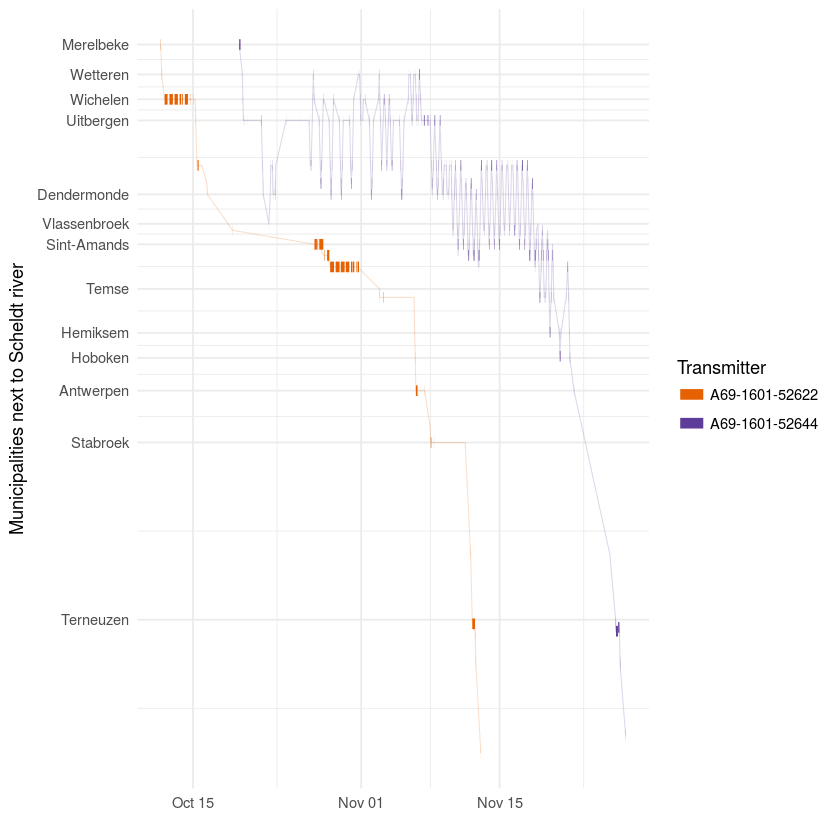

In [200]:
ggplot(eels, aes(x = Arrival, xend = Departure, 
                 y = distance_to_refence_station, 
                 yend = distance_to_refence_station,
                 color = Transmitter)) +
    geom_segment(size = 3) + xlab("") + ylab("") +
    geom_line(data = eels, aes(x = Arrival, y = distance_to_refence_station), 
              alpha = 0.2, size = 0.3) +
    scale_y_continuous("Municipalities next to Scheldt river", 
                       breaks = station_municipality$distance_to_refence_station,
                       labels = station_municipality$municipality) +
    scale_color_manual(values = c("#e66101", "#5e3c99")) +
    theme_minimal()
    

### Tidal data from Waterinfo

In [37]:
library(wateRinfo)

Using the [tidal stations overview](https://github.com/inbo/wateRinfo/files/1483458/tij_all_identifiers.txt) as discussed on the wateRinfo [GitHub Issues](https://github.com/inbo/wateRinfo/issues/11#issuecomment-345339779), but excluding some none-Scheldt river identifiers:

In [86]:
ts_id_tide <- read_csv("../files/scheldt_tide_waterinfo_identifiers.csv", col_types = cols()) %>%
    filter(grepl(".*10min.base", ts_name)) %>% # use 10min based data
    filter(!station_name %in% c("Walem tij/Rupel", "Duffel-sluis tij", "Lier Molbrug tij/Nete",
                           "Kessel tij/Grote Nete", "Emblem tij/Kleine Nete", 
                           "Mechelen Benedensluis tij/Dijle", "Mechelen Stuw Opwaarts tij/Dijle",
                           "Hombeek tij/Zenne", "Zemst tij/Zenne", "Gentbrugge tij/Zeeschelde",
                           "Waasmunster Manta tij/Durme")) # exclude nonte-scheldt stations

Download the data of these stations for the period equivalent to the data period of the eels tracks data:

In [87]:
tidal_data <- read_csv("../files/tidal_data.csv", col_types = cols())

In [93]:
tidal_data <- tidal_data %>%
    left_join(distance_from_sea, by = c("station_name" = "station"))

In [94]:
head(tidal_data)

ts_id,Timestamp,Value,Quality Code,ID,station_no,ts_name,parametertype_name,stationparameter_name,station_id.x,⋯,station_name,dataprovider,dataowner,Portal_Bekken,reference_station,distance_to_refence_station,station_id.y,longitude,latitude,station_type
2799272,2016-10-11 00:00:00,2.58,40,235,zes21a-1066,zes21aANTW.W_t6.10min.base,h,W,312159,⋯,Antwerpen tij/Zeeschelde,MOW-HIC,HIC,Beneden-Scheldebekken,ws-DL7,80356.65,zes21a-1066,4.397031,51.22882,waterinfo
2799272,2016-10-11 00:10:00,2.43,40,235,zes21a-1066,zes21aANTW.W_t6.10min.base,h,W,312159,⋯,Antwerpen tij/Zeeschelde,MOW-HIC,HIC,Beneden-Scheldebekken,ws-DL7,80356.65,zes21a-1066,4.397031,51.22882,waterinfo
2799272,2016-10-11 00:20:00,2.29,40,235,zes21a-1066,zes21aANTW.W_t6.10min.base,h,W,312159,⋯,Antwerpen tij/Zeeschelde,MOW-HIC,HIC,Beneden-Scheldebekken,ws-DL7,80356.65,zes21a-1066,4.397031,51.22882,waterinfo
2799272,2016-10-11 00:30:00,2.15,40,235,zes21a-1066,zes21aANTW.W_t6.10min.base,h,W,312159,⋯,Antwerpen tij/Zeeschelde,MOW-HIC,HIC,Beneden-Scheldebekken,ws-DL7,80356.65,zes21a-1066,4.397031,51.22882,waterinfo
2799272,2016-10-11 00:40:00,2.03,40,235,zes21a-1066,zes21aANTW.W_t6.10min.base,h,W,312159,⋯,Antwerpen tij/Zeeschelde,MOW-HIC,HIC,Beneden-Scheldebekken,ws-DL7,80356.65,zes21a-1066,4.397031,51.22882,waterinfo
2799272,2016-10-11 00:50:00,1.90,40,235,zes21a-1066,zes21aANTW.W_t6.10min.base,h,W,312159,⋯,Antwerpen tij/Zeeschelde,MOW-HIC,HIC,Beneden-Scheldebekken,ws-DL7,80356.65,zes21a-1066,4.397031,51.22882,waterinfo


Warning message:
“Removed 1 rows containing missing values (geom_segment).”

Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_segment).”

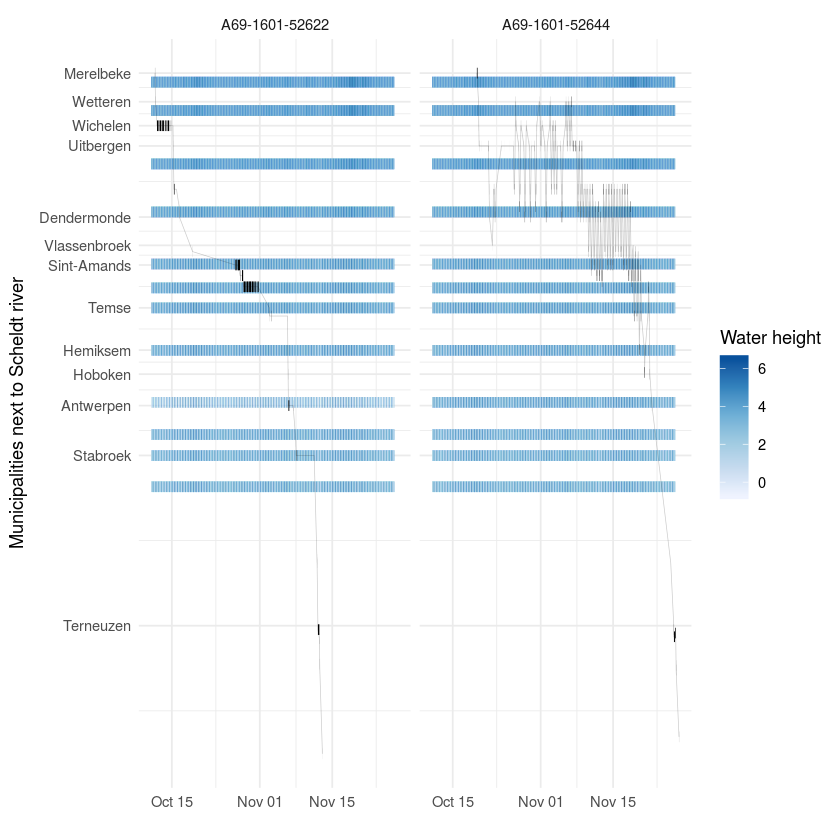

In [168]:
ggplot() +
    geom_segment(data = tidal_data, aes(x = Timestamp, xend = lag(Timestamp),
                 y = distance_to_refence_station, yend = distance_to_refence_station,
                 color = Value), size = 3) + 
    scale_color_distiller("Water height", type = "seq", palette = "Blues", direction = 1) +
    geom_segment(data = eels, aes(x = Arrival, xend = Departure, 
                 y = distance_to_refence_station, yend = distance_to_refence_station), 
                 size = 3) +
    geom_line(data = eels, aes(x = Arrival, y = distance_to_refence_station), 
              alpha = 0.2, size = 0.2) +
    xlab("") + ylab("") +
    scale_y_continuous("Municipalities next to Scheldt river", 
                       breaks = station_municipality$distance_to_refence_station,
                       labels = station_municipality$municipality) +
    theme_minimal() + facet_wrap(~Transmitter)
ggsave(filename = "eels_behavior_1.png", dpi = 300)

## Focus on tag A69-1601-52644

In [188]:
start_moment <- "2016-11-14"
end_moment <- "2016-11-30"

In [189]:
eels %>% filter(Departure >= start_moment, Arrival <= end_moment,
                Transmitter == "A69-1601-52644") -> eels_subset
tidal_data %>% filter(Timestamp >= start_moment, Timestamp <= end_moment) -> tidal_data_subset

Warning message:
“Removed 1 rows containing missing values (geom_segment).”

Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_segment).”

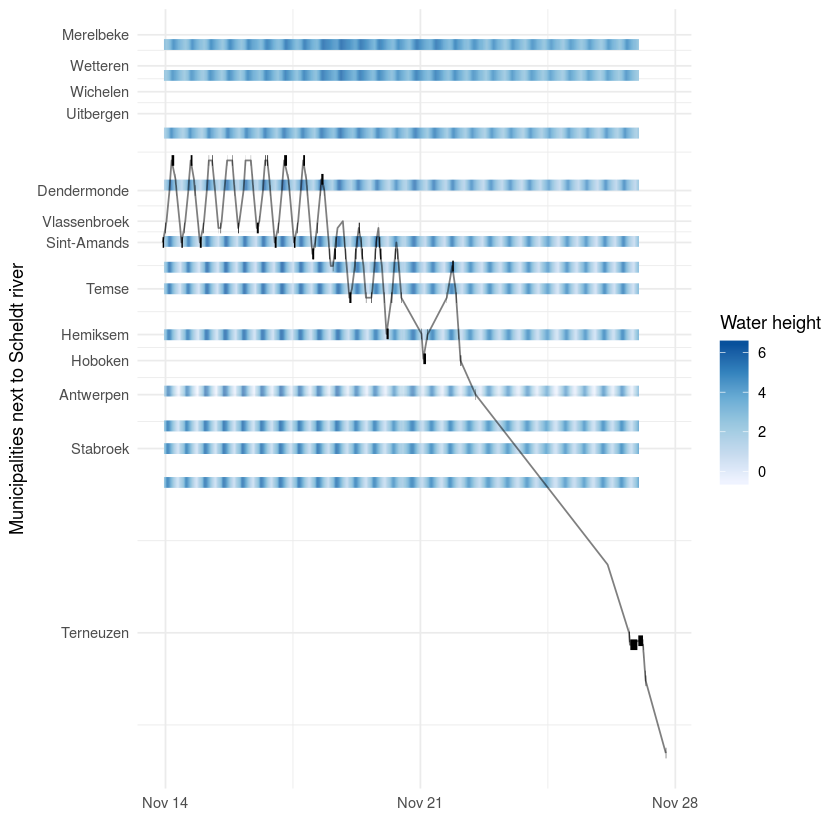

In [191]:
ggplot() +
    geom_segment(data = tidal_data_subset, aes(x = Timestamp, xend = lag(Timestamp),
                 y = distance_to_refence_station, yend = distance_to_refence_station,
                 color = Value), size = 3) + 
    scale_color_distiller("Water height", type = "seq", palette = "Blues", direction = 1) +
    geom_segment(data = eels_subset, aes(x = Arrival, xend = Departure, 
                 y = distance_to_refence_station, yend = distance_to_refence_station), 
                 size = 3) +
    geom_line(data = eels_subset, aes(x = Arrival, 
                                      y = distance_to_refence_station),
              alpha = 0.5) +
    xlab("") + ylab("") +
    scale_y_continuous("Municipalities next to Scheldt river", 
                       breaks = station_municipality$distance_to_refence_station,
                       labels = station_municipality$municipality) +
    theme_minimal()
ggsave(filename = "eels_behavior_3.png", dpi = 300)

## Focus on tag A69-1601-52622

In [196]:
start_moment <- "2016-10-15"
end_moment <- "2016-11-07"

eels %>% filter(Departure >= start_moment, Arrival <= end_moment,
                Transmitter == "A69-1601-52622") -> eels_subset
tidal_data %>% filter(Timestamp >= start_moment, Timestamp <= end_moment) -> tidal_data_subset

Warning message:
“Removed 1 rows containing missing values (geom_segment).”

Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_segment).”

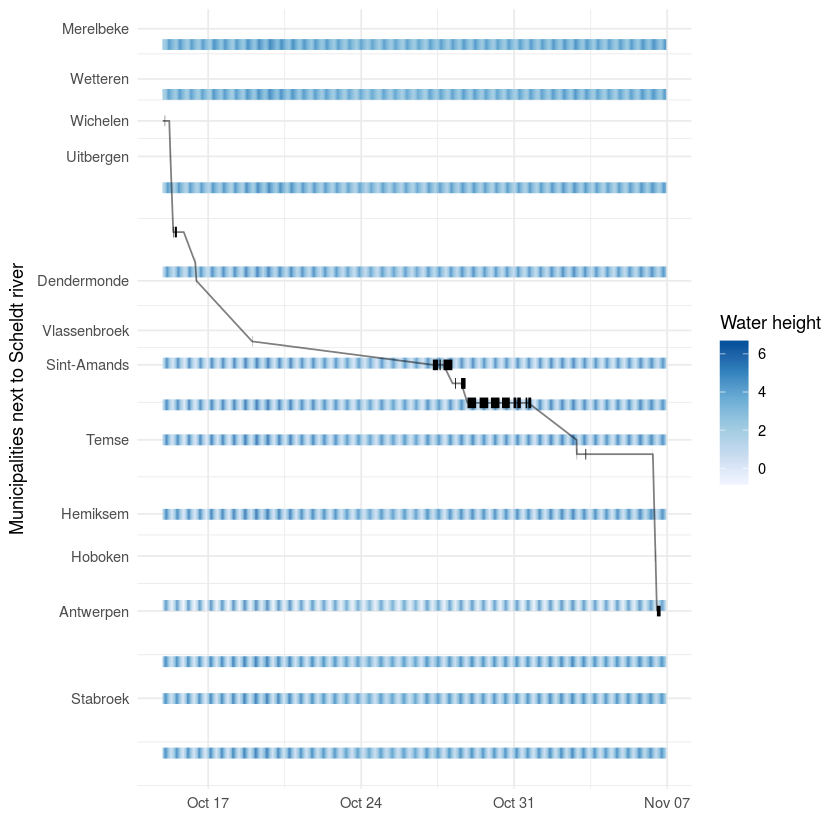

In [198]:
ggplot() +
    geom_segment(data = tidal_data_subset, aes(x = Timestamp, xend = lag(Timestamp),
                 y = distance_to_refence_station, yend = distance_to_refence_station,
                 color = Value), size = 3) + 
    scale_color_distiller("Water height", type = "seq", palette = "Blues", direction = 1) +
    geom_segment(data = eels_subset, aes(x = Arrival, xend = Departure, 
                 y = distance_to_refence_station, yend = distance_to_refence_station), 
                 size = 3) +
    geom_line(data = eels_subset, aes(x = Arrival, 
                                      y = distance_to_refence_station),
              alpha = 0.5) +
    xlab("") + ylab("") +
    scale_y_continuous("Municipalities next to Scheldt river", 
                       breaks = station_municipality$distance_to_refence_station,
                       labels = station_municipality$municipality) +
    theme_minimal()
ggsave(filename = "eels_behavior_4.png", dpi = 300)

In [83]:
#ggplot(tidal_data, aes(x = Timestamp, y  = station_no, color = Value)) +
#    geom_tile()

TODO:
- mee po figuur zetten
- kaartversie maken